In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder,CountEncoder
from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, mean_squared_error, mean_squared_log_error, log_loss
from sklearn.model_selection import StratifiedKFold,KFold
import time
import random

%matplotlib inline
import lightgbm as lgb
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV,Lasso,Ridge,ElasticNet
from sklearn.svm import SVR

In [398]:
def cleaning_data(df):
    cats = []
    for col in df.columns:
        if df[col].dtype == 'object':
            cats.append(col)      
#             print(col, df[col].nunique())
    
    num_cats=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            num_cats.append(col)      
#             print(col, df[col].nunique())
    
    num_cols=[
     'prev3_div',
     'prev2_div',
     'prev1_div',
     'prev3_num_played',
     'prev2_num_played',
     'prev1_num_played',
     'prev3_scores',
     'prev2_scores',
     'prev1_scores',
     'prev3_time_played',
     'prev2_time_played',
     'prev1_time_played',
     'BMI']
    
    cat_cols=['team',
     'name',
     'position',
     'birthdate',
     'is_youth',
     'nationality',
     'prev3_team',
     'prev2_team',
     'prev1_team',
             ]
    df['BMI'] = df['weight'].astype('float')/df['height'].astype('float')**2*10000
    df[cat_cols] = df[cat_cols].replace('-','null')
    df[num_cols] = df[num_cols].replace('-','0') 

    scaler = StandardScaler()
    df[num_cats] = scaler.fit_transform(df[num_cats])
    
    df[num_cols] = df[num_cols].fillna(0)
    df[num_cols] = df[num_cols].astype(int)
    df[num_cols] = scaler.fit_transform(df[num_cols])

    df['salary'] = df['salary'].replace('-','0')
    df['salary'] = df['salary'].astype(int)
    df['salary'] = df['salary'].fillna(df['salary'].median())
    df['salary'] = np.log1p(df['salary'])
    
    oe = OrdinalEncoder(cols=cat_cols, return_df=False)
    df[cat_cols] = oe.fit_transform(df[cat_cols])
    
    return df

In [399]:
def count_mis(df):
    df['missing_count'] = df.isnull().sum(axis=1)
    return df

def mis_pattern(df):
    m = df.isnull().sum()
    cols_with_missing = list(m[m != 0].index)

    df['missing_pattern'] = 0
    for col in cols_with_missing:
        df['missing_pattern'] *= 2
        df.loc[df[col].isnull(), 'missing_pattern'] += 1
    
    df['missing_pattern'] *= 1e-16
    return df

In [400]:
def mung_data(df):
    
    pass

In [401]:
def modeling(df):
    pass

In [402]:
def output(df):
    pass

In [403]:
if __name__ == "__main__":
    data1 = pd.read_csv('train_2016.csv')
    data2 = pd.read_csv('train_2017.csv')
    data3 = pd.read_csv('train_2018.csv')
    
    concatenate_data = pd.concat([data1,data2,data3])
    
    train = concatenate_data.copy()
    test = pd.read_csv('test.csv')
    test['time_played']=-999
    
    df_all = pd.concat([concatenate_data,test])
    train_y = df_all['time_played']
    df_all.drop(['id','No','time_played'],axis=1,inplace=True)
    
    df_all = count_mis(df_all)
    df_all = mis_pattern(df_all)
    df_cleaned = cleaning_data(df_all)
    df_cleaned['time_played']=train_y
    df_cleaned.fillna(-1,inplace=True)
    
    train_x = df_cleaned[df_cleaned['time_played']!=-999]
    test_x =df_cleaned[df_cleaned['time_played']==-999]
    train_y = train_x['time_played']
    
    train_x.drop('time_played',axis=1,inplace=True)
    test_x.drop('time_played',axis=1,inplace=True)
    

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [404]:
params = {"objective": 'regression',
          "boosting_type": "gbdt",
          "learning_rate": 0.01,
          "num_leaves": 50,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 1e-3,
          "min_split_gain": 0.0,
          "subsample": 1.0,
          "metric": "rmse",
    }

In [405]:
scores = []
total_time=0
r_seed=10

predictions = pd.DataFrame()
predictions = predictions.fillna(0)
print(predictions)

kf = KFold(n_splits=5)

for i, (train_ix, test_ix) in tqdm(enumerate(kf.split(train_x, train_y))):
    t0 = time.time()
    X_train_, y_train_ = train_x.values[train_ix], train_y.values[train_ix]
    X_val, y_val = train_x.values[test_ix], train_y.values[test_ix]
        
    ##define model
    lr=LGBMRegressor(n_estimators=9999, random_state=r_seed,max_depth=15,**params)
    
    ##modeling
    lr.fit(X_train_, y_train_, early_stopping_rounds=100, eval_metric='rmse', eval_set=[(X_val, y_val)], verbose=100)
    
    ##predict test data
    y_pred_val = lr.predict(X_val)
    
    #
    score = mean_squared_error(y_val, y_pred_val)**0.5
    scores.append(score)
    
    y_pred=lr.predict(test_x)
    predictions = pd.concat([predictions,pd.DataFrame(y_pred,columns=['pred'+str(i)])],axis=1)
    print('トレーニング時間{}秒'.format(time.time() - t0))
    
    total_time += time.time()-t0
    print('CV Score of Fold_%d is %f' % (i, score))
    
    r_seed=random.randint(1,100)

print('total:{} sec'.format(total_time))

Empty DataFrame
Columns: []
Index: []


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 796.985
[200]	valid_0's rmse: 764.898
[300]	valid_0's rmse: 762.046
Early stopping, best iteration is:
[299]	valid_0's rmse: 761.888
トレーニング時間1.7889719009399414秒
CV Score of Fold_0 is 761.887612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 867.135
[200]	valid_0's rmse: 838.25
[300]	valid_0's rmse: 834.147
[400]	valid_0's rmse: 832.633
Early stopping, best iteration is:
[340]	valid_0's rmse: 830.773
トレーニング時間1.7400004863739014秒
CV Score of Fold_1 is 830.772577
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 846.793
[200]	valid_0's rmse: 843.344
Early stopping, best iteration is:
[147]	valid_0's rmse: 836.558
トレーニング時間0.940460205078125秒
CV Score of Fold_2 is 836.557684
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 891.187
[200]	valid_0's rmse: 866.853
[300]	valid_0's rmse: 860.059
[400]	valid_0's 

In [406]:
np.mean(scores)

825.1344948047187

In [407]:
pred_mean = predictions.mean(axis=1)

In [408]:
pred_mean

0      1400.305000
1      1913.771598
2      1371.947352
3       441.488985
4      1517.297091
          ...     
483     722.985138
484     392.392725
485    1925.415334
486    1337.517813
487     721.838465
Length: 488, dtype: float64

In [409]:
submission = pd.read_csv('sample_submission.csv')

In [410]:
submission['time_played'] = pred_mean

In [411]:
submission['time_played'] =submission['time_played'].round()

In [412]:
submission.to_csv('submit_data.csv',index=False)

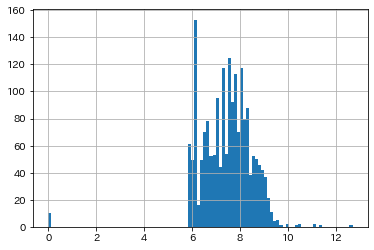

In [413]:
df_cleaned.salary.hist(bins=100)